In [1]:
from pandas import DataFrame
# !pip install ucimlrepo
from ucimlrepo import fetch_ucirepo
import pandas as pd

dec_att = 'ViolentCrimesPerPop'

# fetch dataset
communities_and_crime = fetch_ucirepo(id=183)
df = pd.concat([communities_and_crime.data.features, communities_and_crime.data.targets], axis=1)
df

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,?,?,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,?,?,?,?,0.00,?,0.09
1990,6,?,?,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,?,?,?,?,0.00,?,0.45
1991,9,9,80070,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1992,25,17,72600,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


In [2]:
def camelCase(word: str) -> str:
    return word[0].lower()+word[1:]

df.columns = list(map(camelCase, df.columns))
df.drop(columns=['fold', 'state', 'county', 'community', 'communityname' ], inplace=True)
import numpy as np
df.replace('?', np.nan, inplace=True)
df.drop(columns=df.columns[df.isnull().sum() > 1000], inplace=True)
df.shape

(1994, 101)

In [3]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
df['otherPerCap'] = imputer.fit_transform(df[['otherPerCap']])
df["otherPerCap"].isna().sum()

0

In [4]:
X = df[df.columns[:-1]]
y = df[df.columns[-1]]
print(f"X: {X.shape}; y:{y.shape};")
# correlation_matrix = X.corr()
#
# # Drop one feature from each pair with correlation > 0.85
# high_corr_features = dict()
# corr_threshold = 0.85
# for i in range(len(correlation_matrix.columns)):
#     for j in range(i):
#         v = correlation_matrix.iloc[i, j]
#         if abs(v) > corr_threshold:
#             high_corr_features[correlation_matrix.columns[i]] = v

# print(len(high_corr_features.keys()))
# print(high_corr_features)

X: (1994, 100); y:(1994,);


In [5]:
# X.drop(columns=high_corr_features.keys(), inplace=True)

40


In [5]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})
#sort
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

def get_importance_threshold_dataset(sorted_feature_importance_df, threshold):
    cumulative_importance = np.cumsum(sorted_feature_importance_df['Importance'])
    #Find the number of features needed to reach 90% importance
    num_features = np.argmax(cumulative_importance >= threshold) + 1

    pairs = zip(sorted_feature_importance_df['Feature'], sorted_feature_importance_df["Importance"])
    lowest_acceptable_importance = sorted_feature_importance_df["Importance"][::-1][num_features - 1]
    important_features = [f for f, imp in pairs if imp >= lowest_acceptable_importance]
    X_filtered = X[important_features]
    # print(f"Before: {sorted_feature_importance_df.shape[0]}; after: {X_filtered.shape[1]};")
    return X_filtered

In [6]:
datasets = {}
datasets["100%_importance"] = X
for threshold in range (30, 91, 10):
    datasets[f"{threshold:03d}%_importance"] = get_importance_threshold_dataset(feature_importance_df, threshold/100)

def print_datasets(datasets):
    for k,v in datasets.items():
        print(k, v.shape)
print_datasets(datasets)

100%_importance (1994, 100)
030%_importance (1994, 74)
040%_importance (1994, 69)
050%_importance (1994, 69)
060%_importance (1994, 3)
070%_importance (1994, 25)
080%_importance (1994, 85)
090%_importance (1994, 92)


In [7]:
# for k,v in datasets.items():
#     print(f'{k}: {"agePct12t29" in v.columns}')

In [8]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
best_models = {}  # Store best models for each dataset
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10]
}
for name, X_filtered in datasets.items():
    print(f"Running RandomizedSearchCV for {name}...")

    model = XGBRegressor(objective='reg:squarederror', random_state=42)

    search = RandomizedSearchCV(
        model, param_distributions=param_grid,
        n_iter=20, scoring='neg_root_mean_squared_error',
        cv=5, verbose=1, n_jobs=-1, random_state=42
    )

    search.fit(X_filtered, y)

    best_models[name] = search.best_estimator_
    print(f"Best RMSE for {name}: {-search.best_score_:.4f}")

Running RandomizedSearchCV for 100%_importance...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RMSE for 100%_importance: 0.1361
Running RandomizedSearchCV for 030%_importance...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RMSE for 030%_importance: 0.1368
Running RandomizedSearchCV for 040%_importance...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RMSE for 040%_importance: 0.1367
Running RandomizedSearchCV for 050%_importance...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RMSE for 050%_importance: 0.1367
Running RandomizedSearchCV for 060%_importance...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RMSE for 060%_importance: 0.1458
Running RandomizedSearchCV for 070%_importance...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RMSE for 070%_importance: 0.1361
Running RandomizedSearchCV for 080%_importance...
Fitting 5 folds for each of 20 candidates, totalli

In [9]:
# models = {f"xgb ({k[:4]})":v for k, v in best_models.items()}
models = {}
models = {k:v for k, v in best_models.items()}
models.keys()

dict_keys(['100%_importance', '030%_importance', '040%_importance', '050%_importance', '060%_importance', '070%_importance', '080%_importance', '090%_importance'])

In [10]:
results = {
    "model_name":[],
    "mae":[],
    "mse":[],
    "r2":[],
    "time":[]
}

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import time
def fit_and_eval(model:XGBRegressor,model_name:str, X:pd.DataFrame, y:pd.DataFrame):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    start = time.time()
    model.fit(X_train,y_train)
    t = time.time()-start
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)

    results["model_name"].append(model_name)
    results["mae"].append(mae)
    results["mse"].append(mse)
    results["r2"].append(r2)
    results["time"].append(t)

In [12]:
from tqdm import tqdm
for model_name, model in tqdm(models.items()):
    fit_and_eval(model, model_name, datasets[model_name], y)


100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


In [13]:
df_results = pd.DataFrame(results)
df_results

,model_name,mae,mse,r2,time
0,100%_importance,0.089653,0.017320,0.643792,0.620857
1,030%_importance,0.090308,0.017417,0.641810,0.545997
2,040%_importance,0.089668,0.017356,0.643067,0.509853
3,050%_importance,0.089668,0.017356,0.643067,0.482799
4,060%_importance,0.093500,0.018347,0.622672,0.091622
5,070%_importance,0.090863,0.018038,0.629026,0.145169
6,080%_importance,0.089198,0.017243,0.645379,0.554875
7,090%_importance,0.090051,0.017499,0.640128,0.330033


In [14]:
import matplotlib.pyplot as plt
def plot_results(metric_name, asc:True):
    data = df_results[metric_name].to_dict()

    model_names = df_results["model_name"]
    metric_values = df_results[metric_name]

    sorted_data = sorted(zip(model_names, metric_values), key=lambda item: item[1], reverse= not asc)
    sorted_model_names, sorted_metric_values = zip(*sorted_data)

    x_pos = np.arange(len(sorted_model_names))

    plt.figure(figsize=(12, 6))
    bars = plt.bar(x_pos, sorted_metric_values)

    plt.xlabel("Models")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} of models")
    plt.xticks(x_pos, sorted_model_names, rotation=45, ha='right')

    for bar, score in zip(bars, sorted_metric_values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{score:.5f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

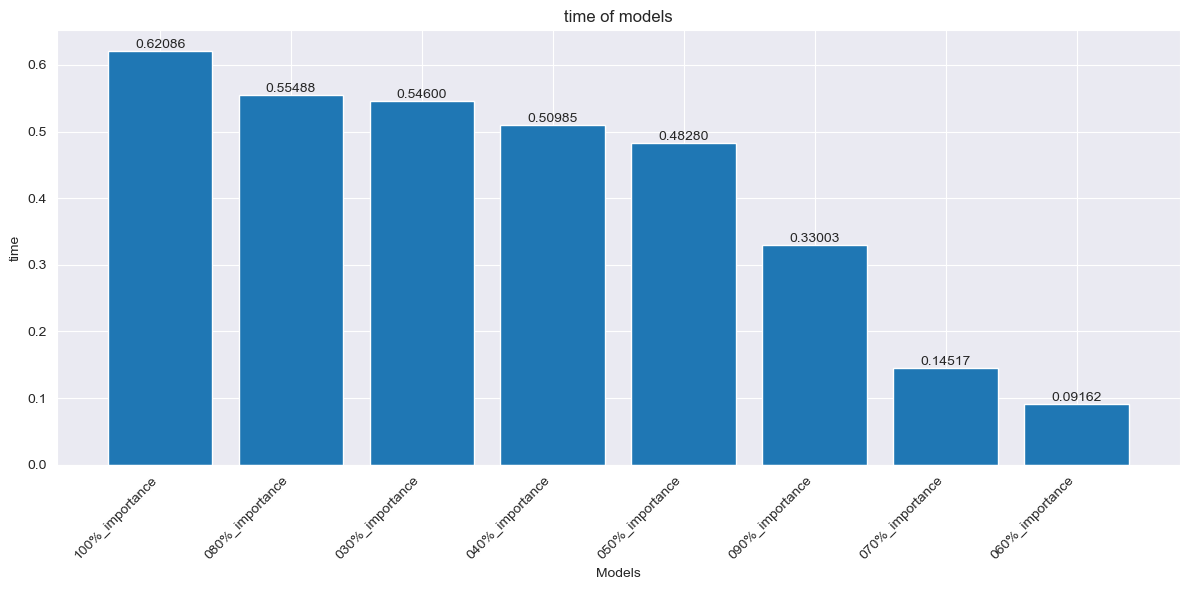

In [16]:
plot_results("time", False)

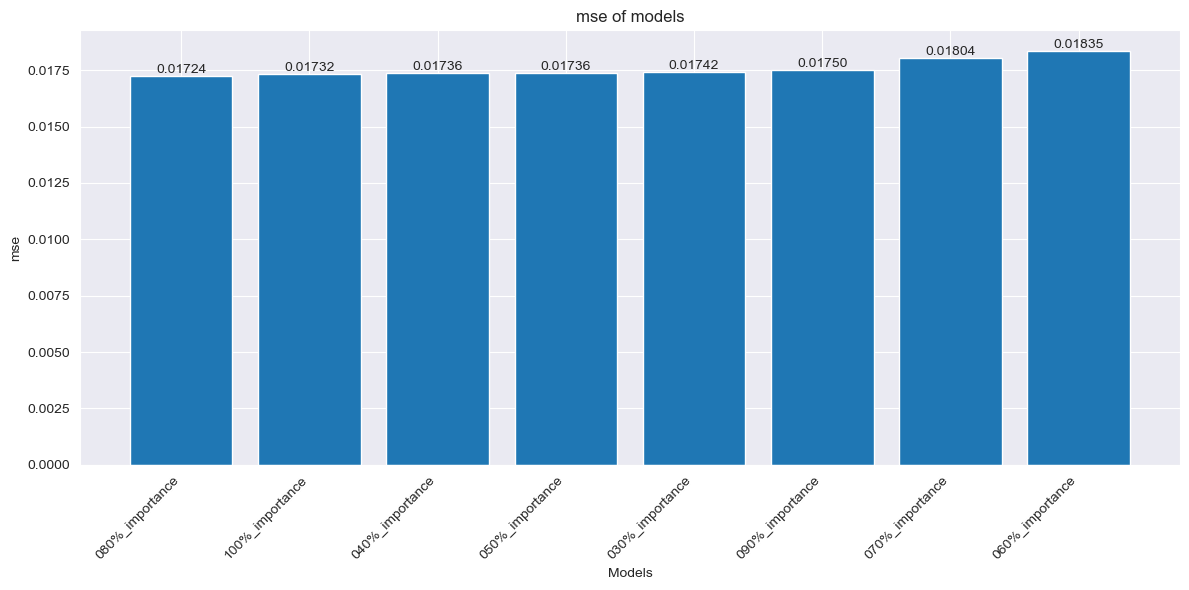

In [17]:
plot_results("mse", True)

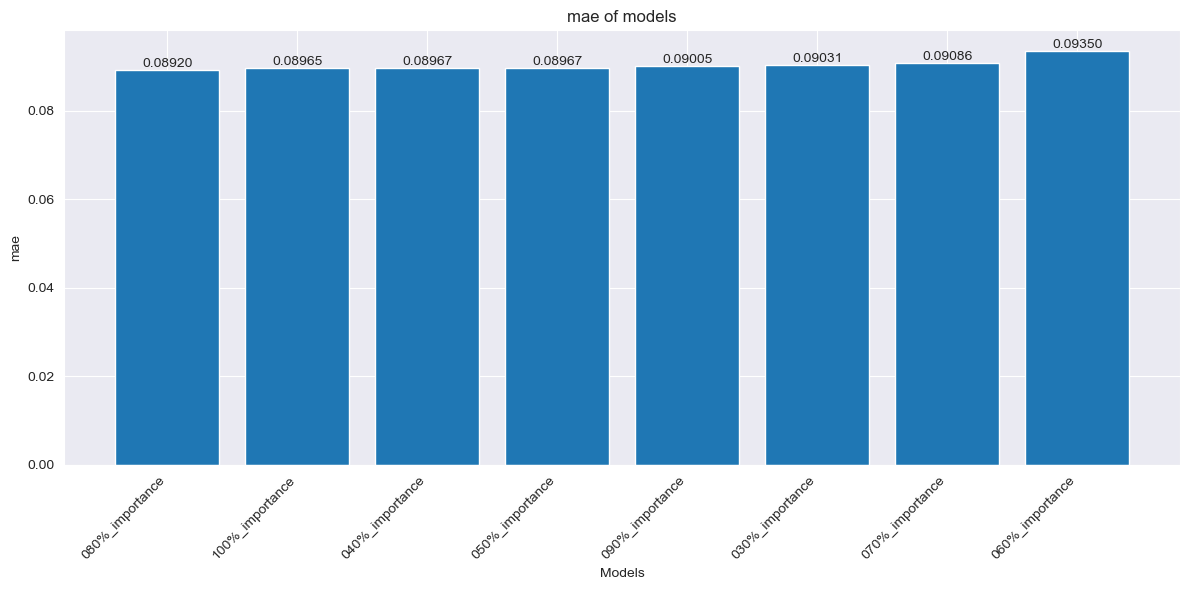

In [18]:
plot_results("mae", True)

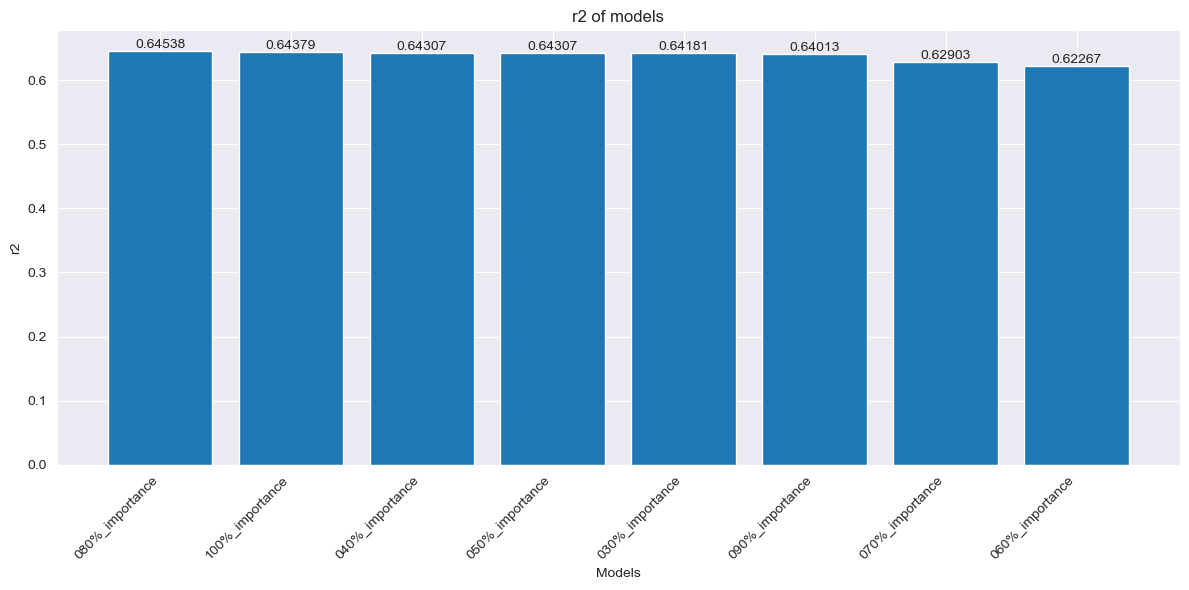

In [19]:
plot_results("r2", False)